In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

os.makedirs('./final_figs', exist_ok=True)

In [5]:
def get_outlier_mask(vector, percentile=100-1):
    threshold = np.percentile(vector, percentile)
    return vector > threshold

def plot_vector(
    vector,
    outlier_mask,
    xlabel,
    ylabel,
    title,
    save_path,
    dot_color = 'red',
    normal_color = 'blue',
    outlier_color = 'green',
    line_alpha = 0.4,
    yrange = None,
    legend = False,
):
    channels = np.arange(vector.shape[0])

    fig, ax = plt.subplots(figsize=(5, 5))

    # plot dots
    ax.plot(channels, vector, 'o', color = dot_color, markersize=1)

    # plot line
    for i in range(len(channels)):
        is_outlier = outlier_mask[i]
        color = outlier_color if is_outlier else normal_color
        alpha = line_alpha if not is_outlier else 1
        ax.plot([channels[i], channels[i]], [0, vector[i]], '-', linewidth=0.5, alpha=alpha, color=color)

    # set y range to be [0, 1]
    if yrange is not None:
        ax.set_ylim(yrange)

    # plot non-outlier max horizontal line
    # non_outlier_max = torch.max(vector[~outlier_mask]).item()
    # ax.plot([0, len(channels)], [non_outlier_max, non_outlier_max], '--', linewidth=1, color='red')

    # draw legends
    outlier_lines = mlines.Line2D([], [], color=outlier_color, label='Salient Channels')
    normal_lines = mlines.Line2D([], [], color=normal_color, label='Normal Channels')
    normal_max_line = mlines.Line2D([], [], color='red', linestyle='--', label="Normal Channels' Max")
    if legend:
        ax.legend(handles=[outlier_lines, normal_lines, normal_max_line], loc='upper left')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.set_title(title)

    plt.savefig(save_path)

In [6]:
outlier_stats = torch.load('outlier_stats/3_sigma/llama-7b-meta_outlier.pt')
# outlier_stats = torch.load('outlier_stats/3_sigma/opt-6.7b_outlier.pt')

for k, v in outlier_stats.items():
    print(k)

LAYER_ID = 30
# llama
layers = {

    f"model.layers.{LAYER_ID}.input_layernorm": 'Attention Input Projection Layer',
    f"model.layers.{LAYER_ID}.post_attention_layernorm": 'FFN Expansion Layer',
    f"model.layers.{LAYER_ID}.self_attn.o_proj": 'Attention Output Projection Layer',
    f"model.layers.{LAYER_ID}.mlp.down_proj": 'FFN Contraction Layer',
}
# layers = [
#     f"model.layers.{i}.mlp.down_proj" for i in range(32)
# ]
# opt
# layers = [
#     f"model.decoder.layers.{LAYER_ID}.self_attn_layer_norm",
#     f"model.decoder.layers.{LAYER_ID}.self_attn.out_proj",
#     f"model.decoder.layers.{LAYER_ID}.final_layer_norm",
#     f"model.decoder.layers.{LAYER_ID}.fc2",
# ]

model.layers.0.input_layernorm
model.layers.0.self_attn.q_proj
model.layers.0.self_attn.k_proj
model.layers.0.self_attn.v_proj
model.layers.0.self_attn.qkt_matmul
model.layers.0.self_attn.pv_matmul
model.layers.0.self_attn.o_proj
model.layers.0.post_attention_layernorm
model.layers.0.mlp.gate_proj
model.layers.0.mlp.up_proj
model.layers.0.mlp.down_proj
model.layers.1.input_layernorm
model.layers.1.self_attn.q_proj
model.layers.1.self_attn.k_proj
model.layers.1.self_attn.v_proj
model.layers.1.self_attn.qkt_matmul
model.layers.1.self_attn.pv_matmul
model.layers.1.self_attn.o_proj
model.layers.1.post_attention_layernorm
model.layers.1.mlp.gate_proj
model.layers.1.mlp.up_proj
model.layers.1.mlp.down_proj
model.layers.2.input_layernorm
model.layers.2.self_attn.q_proj
model.layers.2.self_attn.k_proj
model.layers.2.self_attn.v_proj
model.layers.2.self_attn.qkt_matmul
model.layers.2.self_attn.pv_matmul
model.layers.2.self_attn.o_proj
model.layers.2.post_attention_layernorm
model.layers.2.mlp.g

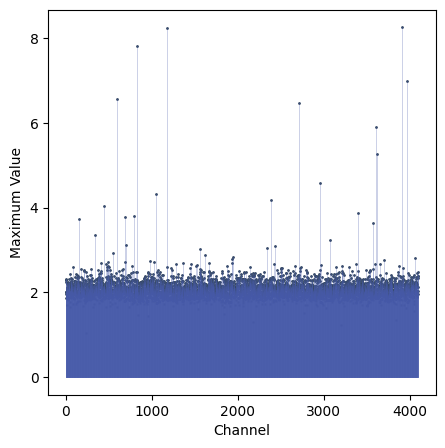

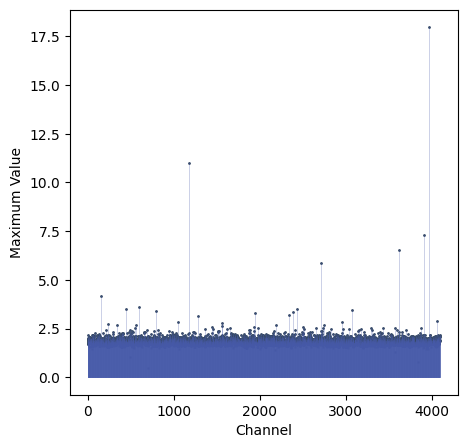

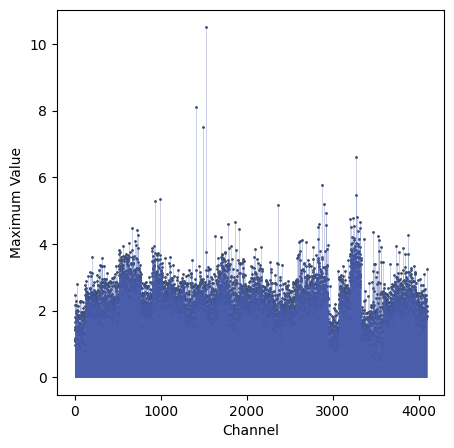

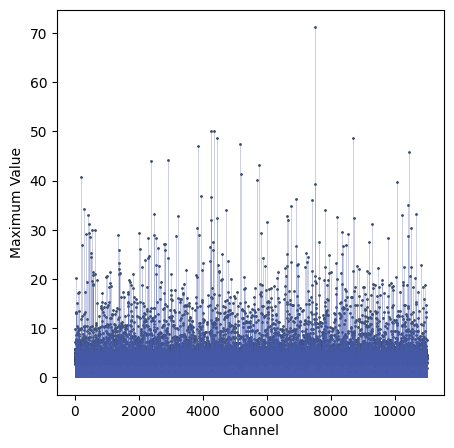

In [9]:
for layer_name in layers:
    category = 'output' if 'norm' in layer_name else 'input'
    outlier_magnitude = outlier_stats[layer_name][category]['channel_max']
    outlier_mask = torch.zeros_like(outlier_magnitude).bool()
    # outlier_mask = get_outlier_mask(outlier_stats[layer_name][category]['channel_max'])

    plot_vector(
        outlier_magnitude,
        outlier_mask,
        'Channel',
        'Maximum Value',
        layers[layer_name],
        f'final_figs/{layer_name}_outlier_magnitude.pdf',
        dot_color = '#354866',
        # normal_color = '#B2D6E6',
        # outlier_color = '#485BAA',
        outlier_color = '#B2D6E6',
        normal_color = '#485BAA',
        line_alpha=0.4,
        yrange=None,
        legend=False
        # legend=(layers[layer_name] == 'FFN Contraction Layer')
    )